In [1]:
# Import functions and helpers
import os, re, io, gzip, requests
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from urllib.parse import urljoin
from concurrent.futures import ThreadPoolExecutor
from scipy.stats import norm 

from data_buoy_helpers import (
    list_station_files,
    fetch_file,
    read_stdmet_max,
    read_stdmet_min,
    collect_station_max,
    collect_station_min,
    read_stdmet,
    load_station 
)

from stat_buoy_helpers import (
    plot_dailymax_seasonal_cycle,
    plot_heatmap,
    plot_time_series_anomalies,
    plot_variance,
    plot_variance_skew,
    # warm-season specific helpers
    get_warm_season_data,
    compute_warm_season_anomalies,
    plot_warm_season_heatmap,
    compare_stations_variance,
    plot_warm_season_time_series
)


# Multi-Buoy Temperature Analysis

This notebook analyzes temperature patterns across multiple NDBC buoys using visualization functions from our statistical analysis toolkit.

In [2]:
# Define buoy stations to analyze
stations = ["46001", "46014", "46025", "desw1"]  # 3 california buoys + one washington

# Load data for all stations
station_data = {}
for station in stations:
    print(f"Loading data for station {station}...")
    result = load_station(station)
    if result is not None:
        # load_station returns (df, completeness), so we extract just the dataframe
        df, completeness = result
        station_data[station] = df
    else:
        print(f"Warning: No data available for station {station}")


Loading data for station 46001...
📡 Found 53 files for station 46001
✅ Parsed 1974: 1411 valid rows.
✅ Parsed 1973: 1696 valid rows.
✅ Parsed 1976: 2401 valid rows.
✅ Parsed 1977: 3096 valid rows.
✅ Parsed 1975: 2889 valid rows.
✅ Parsed 1972: 1889 valid rows.
✅ Parsed 1978: 2941 valid rows.
✅ Parsed 1979: 3990 valid rows.
✅ Parsed 1981: 8608 valid rows.
✅ Parsed 1980: 8712 valid rows.
✅ Parsed 1982: 8544 valid rows.
✅ Parsed 1983: 8610 valid rows.
✅ Parsed 1984: 8665 valid rows.
✅ Parsed 1985: 8735 valid rows.
✅ Parsed 1987: 8689 valid rows.✅ Parsed 1986: 8691 valid rows.

✅ Parsed 1988: 8727 valid rows.
✅ Parsed 1989: 8723 valid rows.
✅ Parsed 1990: 5185 valid rows.
✅ Parsed 1991: 8050 valid rows.
✅ Parsed 1994: 1541 valid rows.
✅ Parsed 1993: 8172 valid rows.
✅ Parsed 1995: 3270 valid rows.
✅ Parsed 1992: 8666 valid rows.
✅ Parsed 1996: 8805 valid rows.
✅ Parsed 1997: 7910 valid rows.
✅ Parsed 1998: 8546 valid rows.
✅ Parsed 1999: 8663 valid rows.
✅ Parsed 2000: 8697 valid rows.
✅ P

c:\Users\ethan\Downloads\Berkeley\Prof Zeppetello Climate Tech Research\zepp\data_buoy_helpers.py:309: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.assign(ATMP=g["ATMP"].interpolate(limit_direction="both")))
c:\Users\ethan\Downloads\Berkeley\Prof Zeppetello Climate Tech Research\zepp\data_buoy_helpers.py:313: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_filled["ATMP"] = df_filled["ATMP"].fillna(method="ffill").fillna(method="bfill")


📡 Found 44 files for station 46014
✅ Parsed 1981: 6051 valid rows.
✅ Parsed 1982: 8683 valid rows.
✅ Parsed 1983: 8475 valid rows.
✅ Parsed 1984: 8720 valid rows.
✅ Parsed 1985: 7915 valid rows.
✅ Parsed 1986: 8679 valid rows.
✅ Parsed 1987: 8572 valid rows.
✅ Parsed 1988: 6515 valid rows.
✅ Parsed 1989: 7434 valid rows.
✅ Parsed 1992: 4837 valid rows.
✅ Parsed 1991: 6865 valid rows.
✅ Parsed 1990: 8207 valid rows.
✅ Parsed 1993: 6051 valid rows.
✅ Parsed 1994: 8622 valid rows.✅ Parsed 1995: 7475 valid rows.

✅ Parsed 1997: 8668 valid rows.
✅ Parsed 1996: 8864 valid rows.
✅ Parsed 1998: 8634 valid rows.
✅ Parsed 1999: 8513 valid rows.
✅ Parsed 2001: 8714 valid rows.
✅ Parsed 2000: 8619 valid rows.
✅ Parsed 2002: 7791 valid rows.
✅ Parsed 2004: 8743 valid rows.
✅ Parsed 2003: 8743 valid rows.
✅ Parsed 2006: 5429 valid rows.
✅ Parsed 2005: 8754 valid rows.
✅ Parsed 2007: 7776 valid rows.
✅ Parsed 2008: 8754 valid rows.
✅ Parsed 2010: 8756 valid rows.
✅ Parsed 2009: 8756 valid rows.
✅ Par

c:\Users\ethan\Downloads\Berkeley\Prof Zeppetello Climate Tech Research\zepp\data_buoy_helpers.py:309: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.assign(ATMP=g["ATMP"].interpolate(limit_direction="both")))
c:\Users\ethan\Downloads\Berkeley\Prof Zeppetello Climate Tech Research\zepp\data_buoy_helpers.py:313: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_filled["ATMP"] = df_filled["ATMP"].fillna(method="ffill").fillna(method="bfill")


📡 Found 43 files for station 46025
✅ Parsed 1982: 6104 valid rows.
✅ Parsed 1984: 8016 valid rows.
✅ Parsed 1985: 8364 valid rows.
✅ Parsed 1983: 8586 valid rows.
✅ Parsed 1987: 7894 valid rows.
✅ Parsed 1986: 8173 valid rows.
✅ Parsed 1989: 5270 valid rows.
✅ Parsed 1988: 8723 valid rows.
✅ Parsed 1990: 7731 valid rows.
✅ Parsed 1991: 7943 valid rows.
✅ Parsed 1992: 8704 valid rows.
✅ Parsed 1993: 8218 valid rows.
✅ Parsed 1995: 7983 valid rows.
✅ Parsed 1994: 7543 valid rows.
✅ Parsed 1996: 8762 valid rows.
✅ Parsed 1997: 5423 valid rows.
✅ Parsed 1998: 8446 valid rows.
✅ Parsed 1999: 8636 valid rows.
✅ Parsed 2000: 8650 valid rows.
✅ Parsed 2001: 8665 valid rows.
✅ Parsed 2002: 8667 valid rows.
✅ Parsed 2003: 8721 valid rows.
✅ Parsed 2004: 8737 valid rows.
✅ Parsed 2005: 8739 valid rows.
✅ Parsed 2006: 8728 valid rows.
✅ Parsed 2007: 8713 valid rows.
✅ Parsed 2009: 8759 valid rows.
✅ Parsed 2012: 3701 valid rows.
✅ Parsed 2008: 8760 valid rows.
✅ Parsed 2011: 8753 valid rows.
✅ Par

c:\Users\ethan\Downloads\Berkeley\Prof Zeppetello Climate Tech Research\zepp\data_buoy_helpers.py:309: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.assign(ATMP=g["ATMP"].interpolate(limit_direction="both")))
c:\Users\ethan\Downloads\Berkeley\Prof Zeppetello Climate Tech Research\zepp\data_buoy_helpers.py:313: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_filled["ATMP"] = df_filled["ATMP"].fillna(method="ffill").fillna(method="bfill")


continuous coverage from 1982–2024 (43 total years)
Loading data for station desw1...
📡 Found 41 files for station desw1
✅ Parsed 1984: 3302 valid rows.
✅ Parsed 1985: 8661 valid rows.
✅ Parsed 1987: 8695 valid rows.
✅ Parsed 1989: 8558 valid rows.
✅ Parsed 1986: 8694 valid rows.
✅ Parsed 1988: 8704 valid rows.
✅ Parsed 1990: 8718 valid rows.
✅ Parsed 1992: 8662 valid rows.
✅ Parsed 1991: 8740 valid rows.
✅ Parsed 1993: 8660 valid rows.
✅ Parsed 1994: 8649 valid rows.
✅ Parsed 1995: 8687 valid rows.
✅ Parsed 1996: 8833 valid rows.
✅ Parsed 1997: 471 valid rows.
✅ Parsed 1998: 8566 valid rows.
✅ Parsed 1999: 8377 valid rows.
✅ Parsed 2000: 8644 valid rows.
✅ Parsed 2001: 8683 valid rows.
✅ Parsed 2002: 8324 valid rows.
✅ Parsed 2003: 8476 valid rows.
✅ Parsed 2004: 8725 valid rows.✅ Parsed 2005: 8707 valid rows.

✅ Parsed 2006: 8684 valid rows.
✅ Parsed 2007: 8683 valid rows.
✅ Parsed 2008: 8716 valid rows.
✅ Parsed 2009: 8703 valid rows.
✅ Parsed 2010: 7908 valid rows.
✅ Parsed 2011: 8

c:\Users\ethan\Downloads\Berkeley\Prof Zeppetello Climate Tech Research\zepp\data_buoy_helpers.py:309: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.assign(ATMP=g["ATMP"].interpolate(limit_direction="both")))
c:\Users\ethan\Downloads\Berkeley\Prof Zeppetello Climate Tech Research\zepp\data_buoy_helpers.py:313: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_filled["ATMP"] = df_filled["ATMP"].fillna(method="ffill").fillna(method="bfill")


In [3]:
print(station_data['46001'])

       year  day_of_year date  ATMP
0      1972            1  NaT   NaN
1      1972            2  NaT   NaN
2      1972            3  NaT   NaN
3      1972            4  NaT   NaN
4      1972            5  NaT   NaN
...     ...          ...  ...   ...
19340  2024          361  NaT   NaN
19341  2024          362  NaT   NaN
19342  2024          363  NaT   NaN
19343  2024          364  NaT   NaN
19344  2024          365  NaT   NaN

[19345 rows x 4 columns]


## Temperature Anomaly Analysis

Compare temperature anomaly patterns across different buoy locations using heatmaps and time series.


Analyzing warm-season temperature anomalies for station 46001


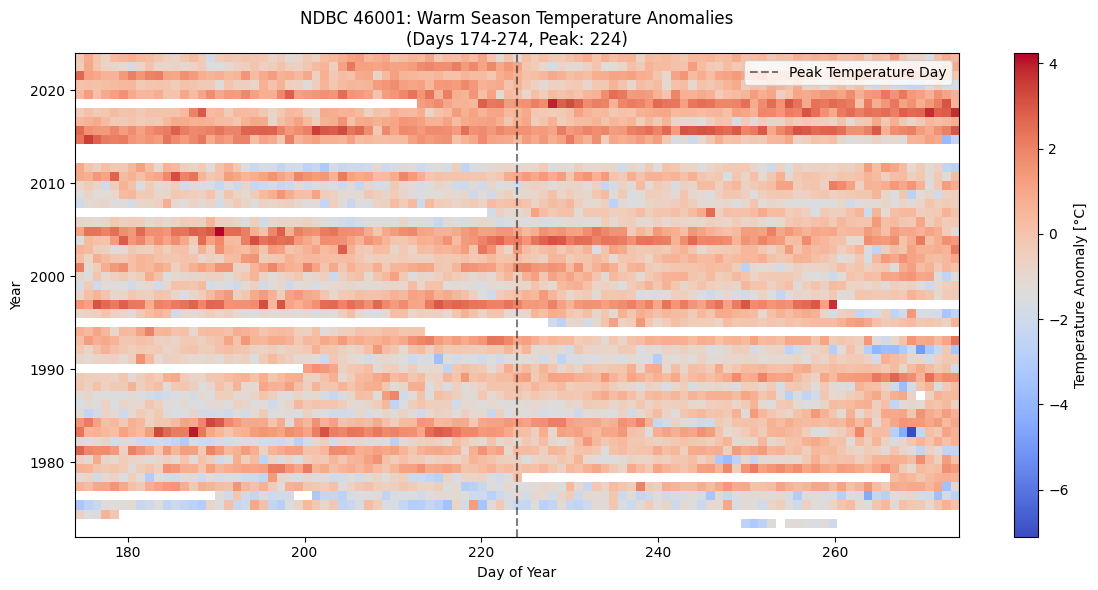

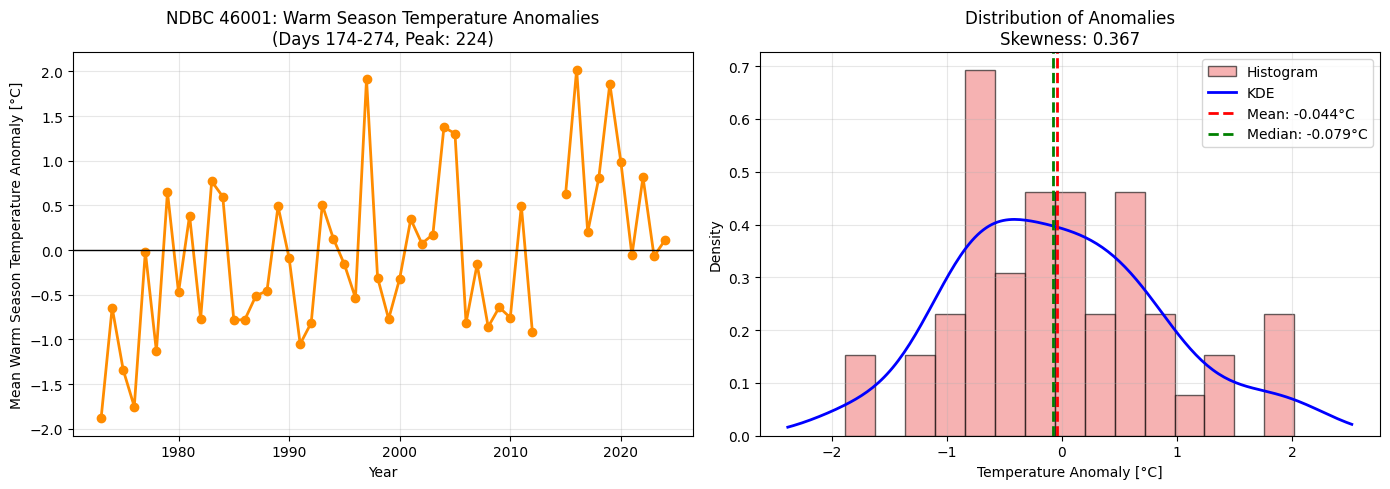


Analyzing warm-season temperature anomalies for station 46014


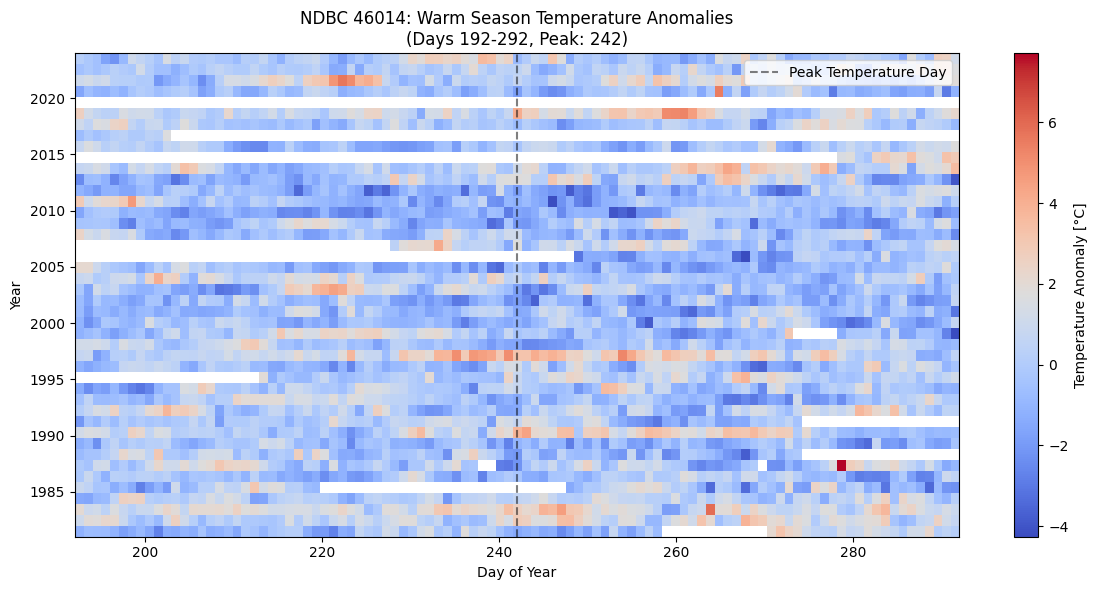

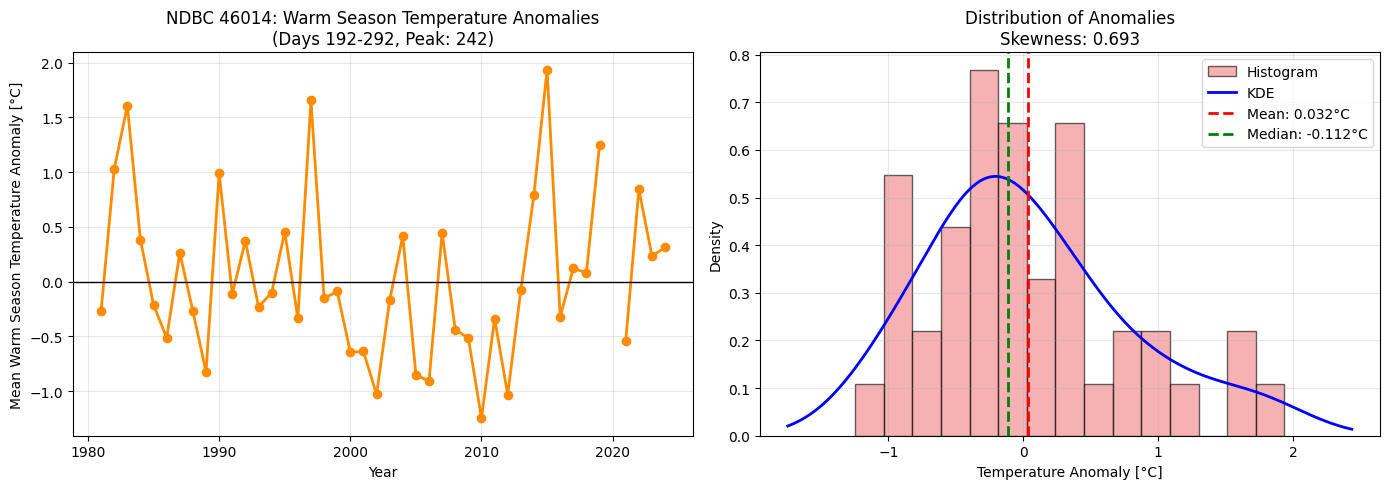


Analyzing warm-season temperature anomalies for station 46025


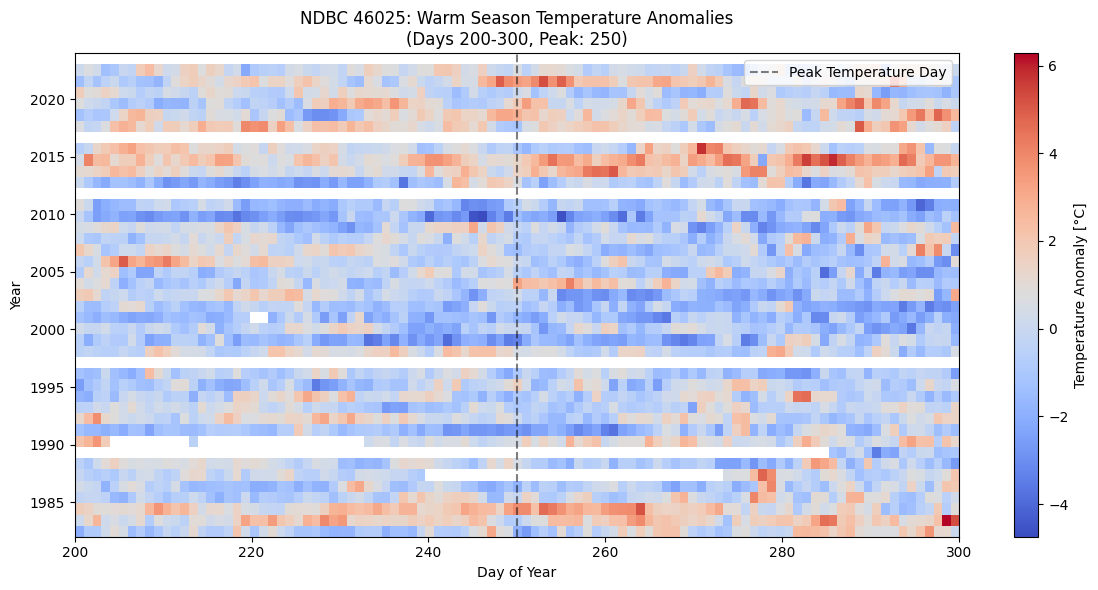

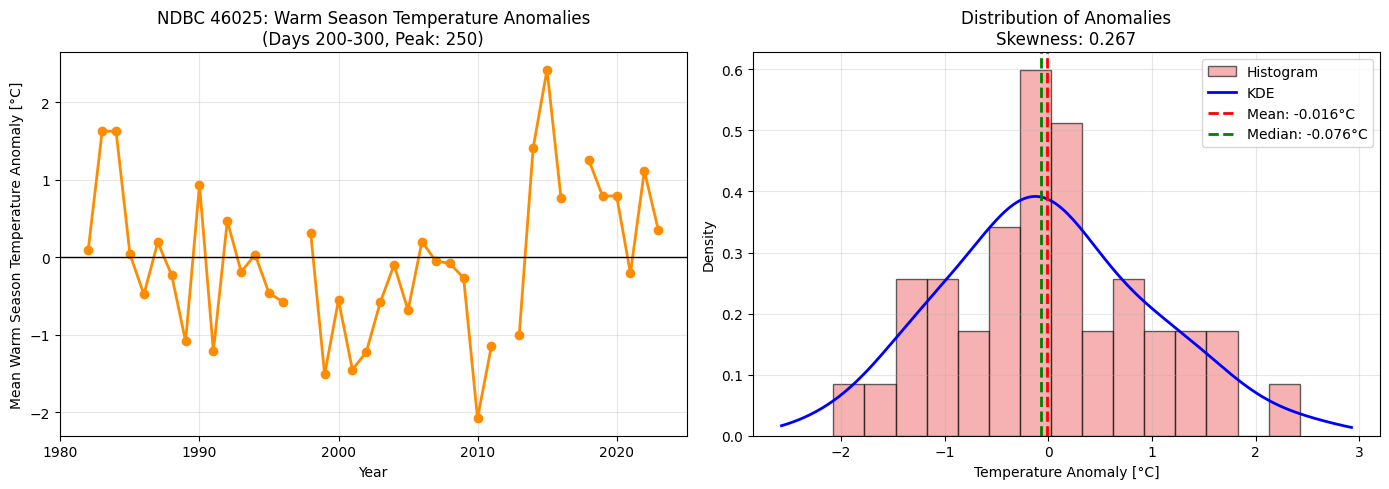


Analyzing warm-season temperature anomalies for station desw1


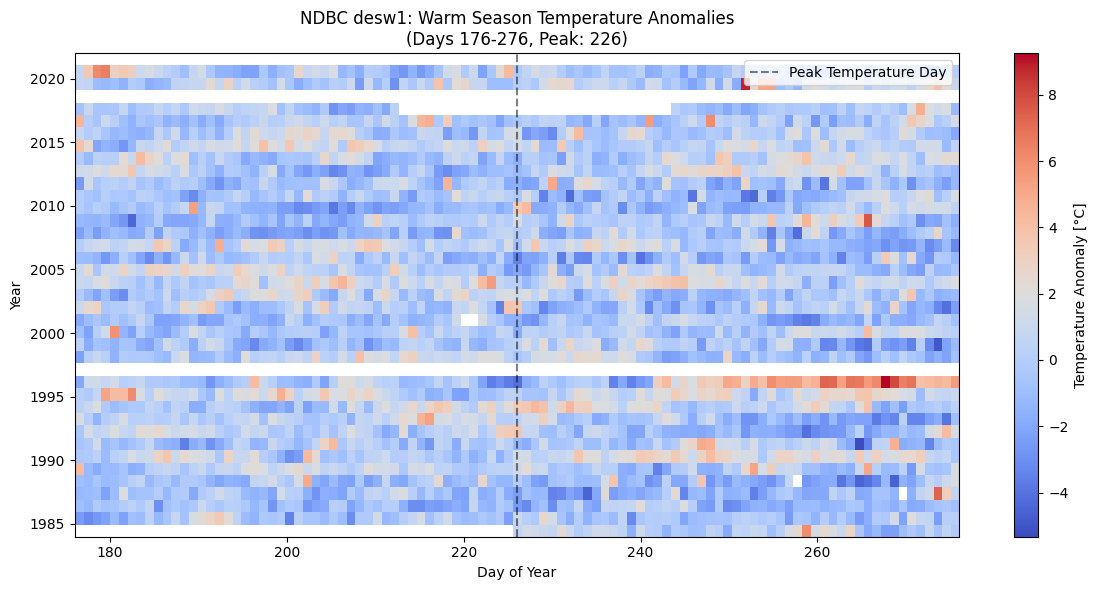

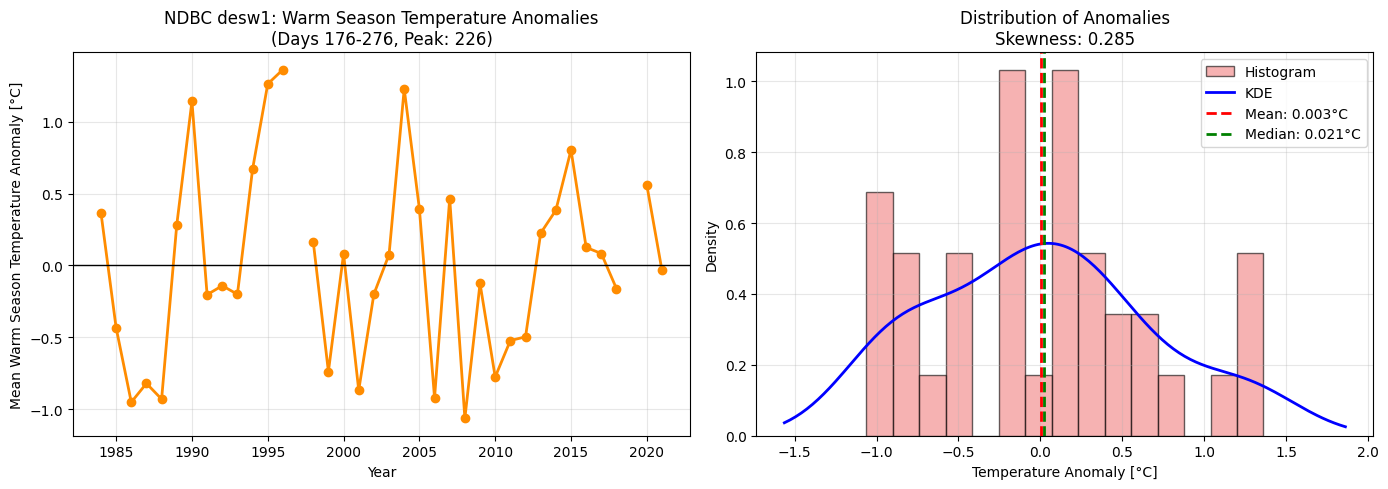

In [4]:
# Generate warm-season heatmaps and time series for each station
for station, data in station_data.items():
    print(f"\nAnalyzing warm-season temperature anomalies for station {station}")

    # Warm-season heatmap (automatically finds climatological peak)
    plot_warm_season_heatmap(data, station, window_size=50)

    # Warm-season annual anomaly time series
    plot_warm_season_time_series(data, station, window_size=50)


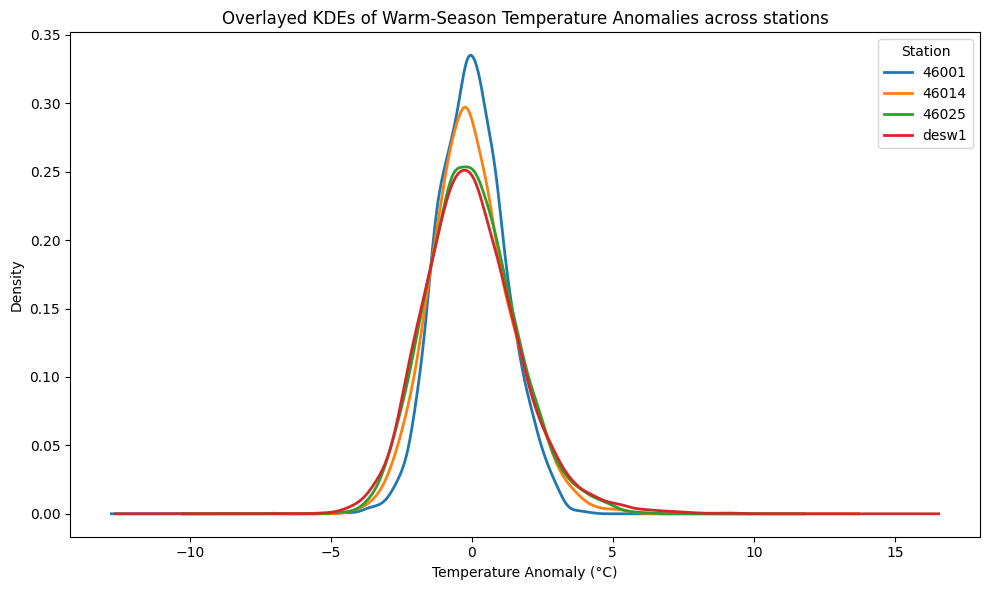

In [ ]:
# Overlay KDEs of warm-season YEARLY mean anomalies for all loaded stations
# Compute per-year warm-season means (one value per year) so densities match the yearly-anomaly KDEs
fig, ax = plt.subplots(figsize=(10, 6))

for station, d in station_data.items():
    try:
        anomalies, mean_cycle, (warm_start, warm_center, warm_end) = compute_warm_season_anomalies(d, window_size=50)
    except Exception as e:
        print(f"Skipping {station}: could not compute warm-season anomalies ({e})")
        continue

    # Compute yearly mean anomaly (one value per year)
    yearly_anom = anomalies.mean(axis=0).dropna()
    if yearly_anom.empty or len(yearly_anom) < 2:
        print(f"Skipping {station}: too few years for KDE")
        continue

    # KDE of yearly means (°C)
    yearly_anom.plot(kind="kde", ax=ax, label=station, lw=2)

ax.set_xlabel("Mean Warm-Season Temperature Anomaly (°C)")
ax.set_ylabel("Density")
ax.set_title("Overlayed KDEs of Warm-Season Yearly Mean Anomalies across stations")
ax.legend(title="Station")
plt.tight_layout()
plt.show()

## Seasonal Variance Analysis

Analyze how temperature variability changes throughout the year at different buoy locations.

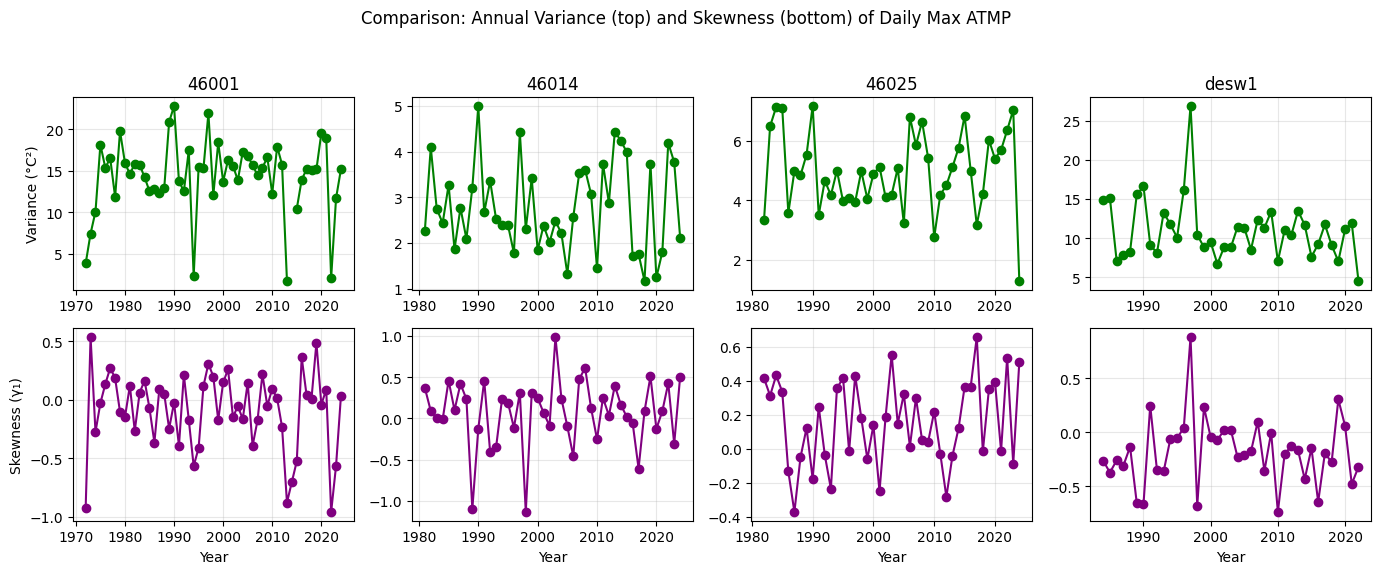

In [5]:
# Compare variance and skew across the loaded stations (side-by-side)
# Use the order in station_data (preserves your load order)
compare_stations_variance(station_data, stations=list(station_data.keys()))



Analyzing variance patterns for station 46001


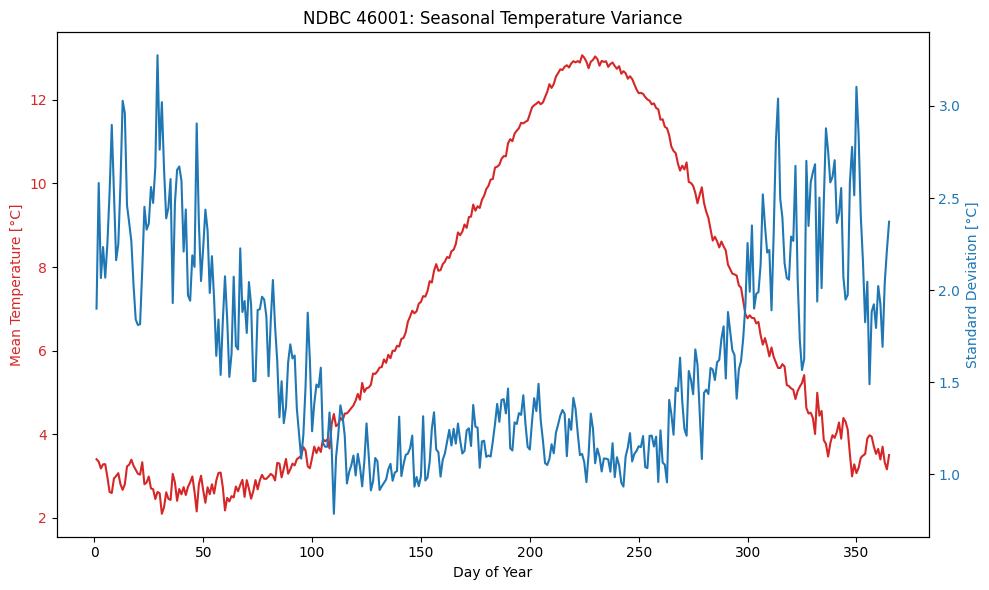

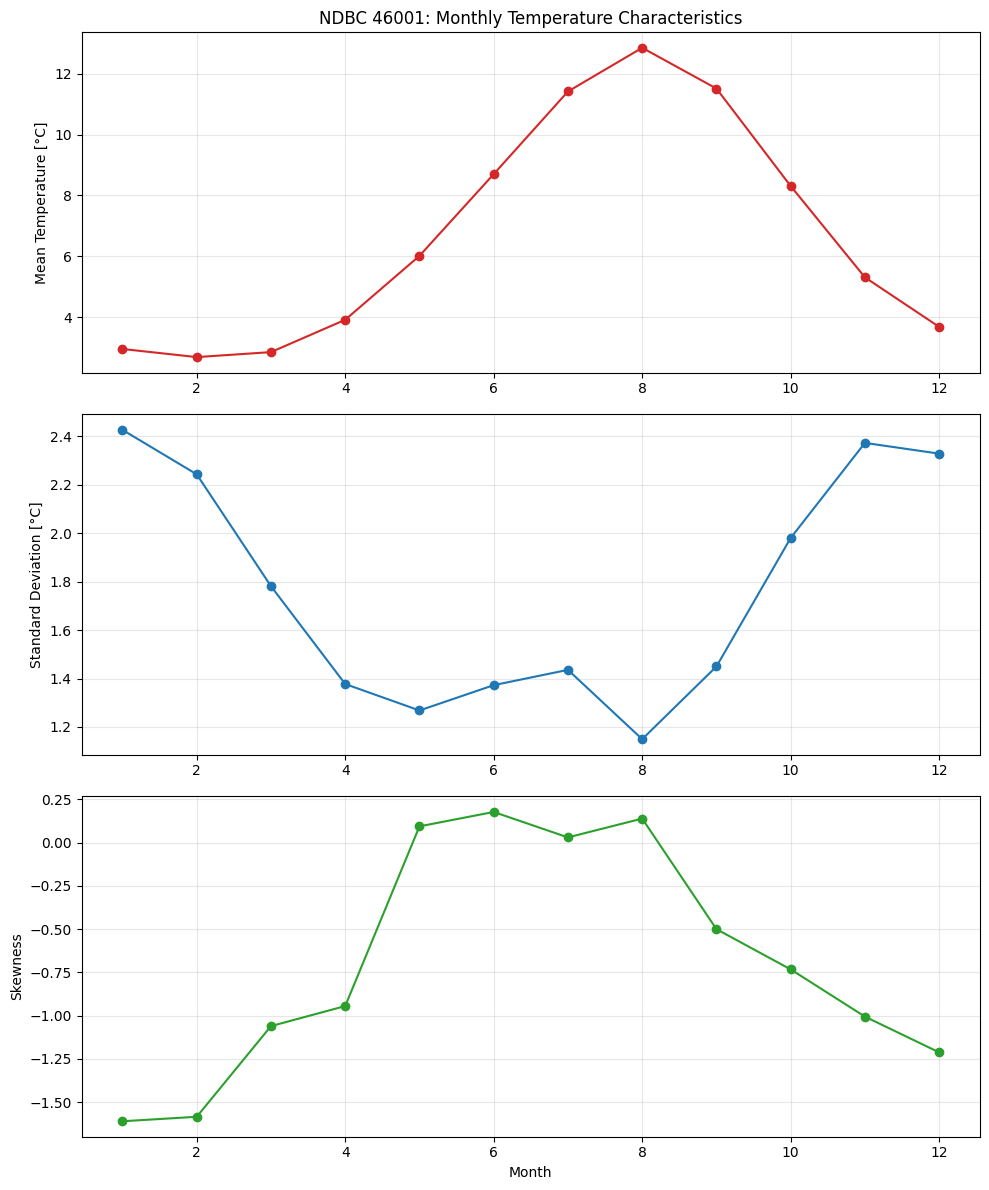


Analyzing variance patterns for station 46014


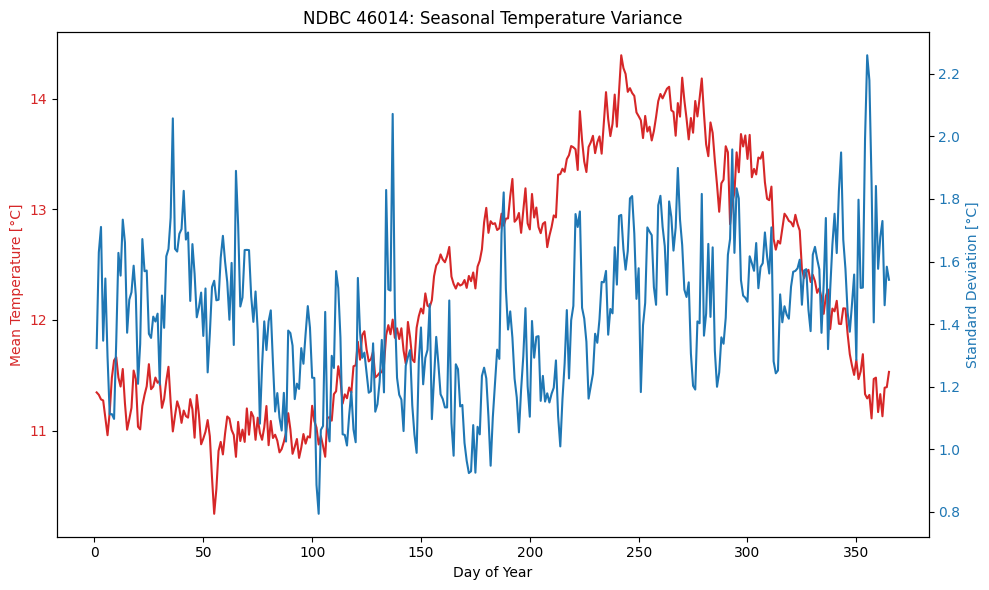

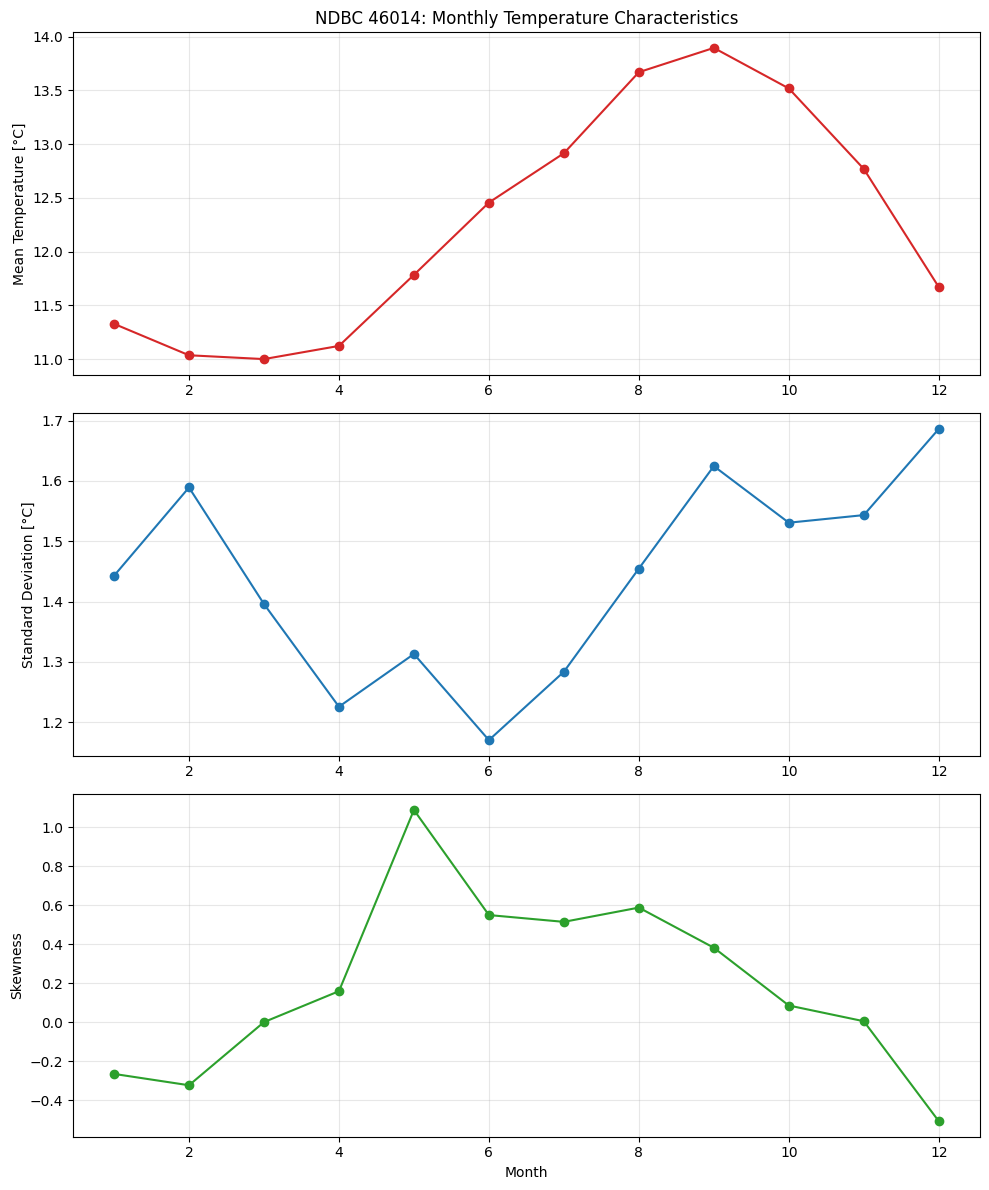


Analyzing variance patterns for station 46025


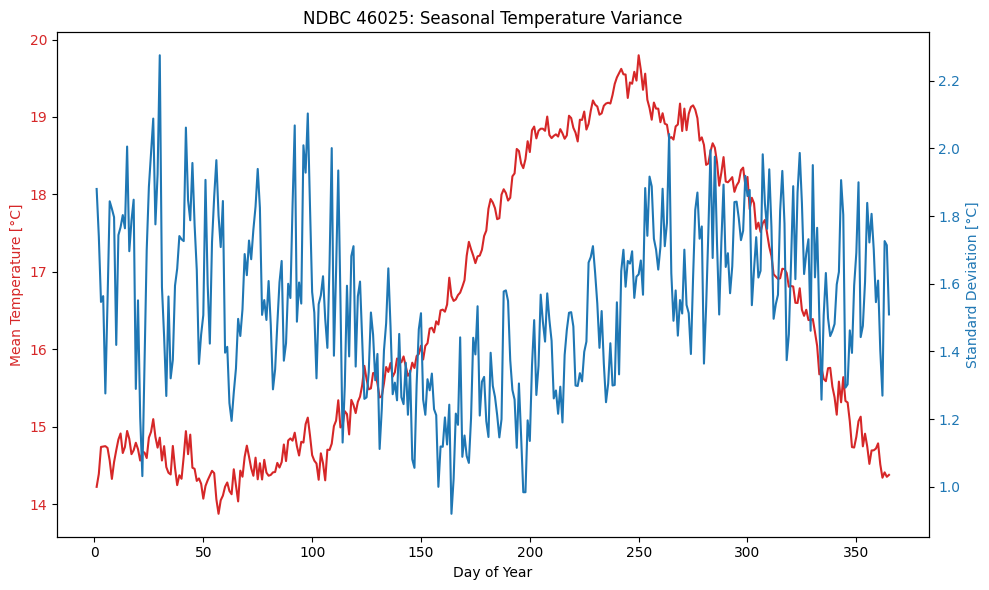

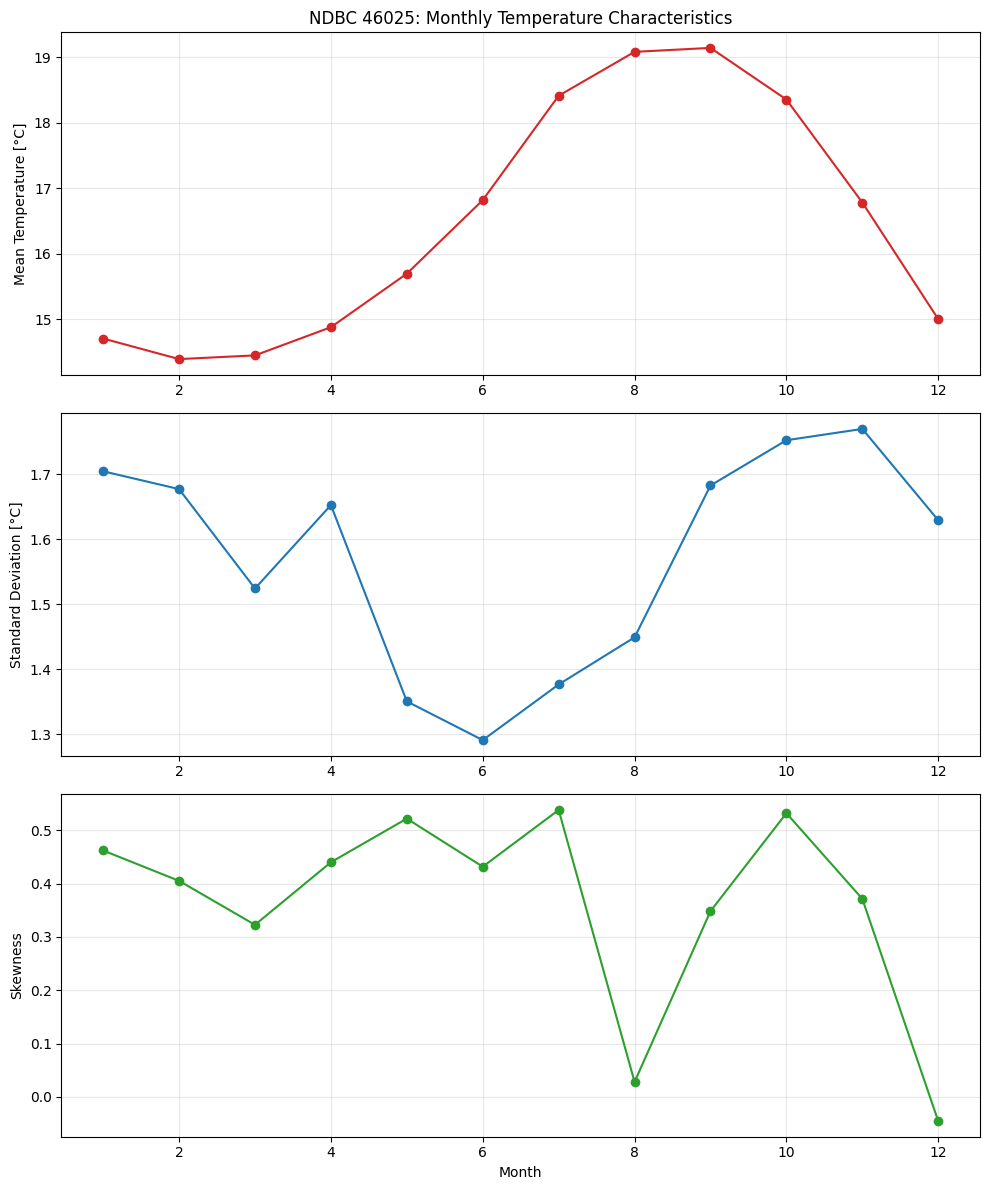


Analyzing variance patterns for station desw1


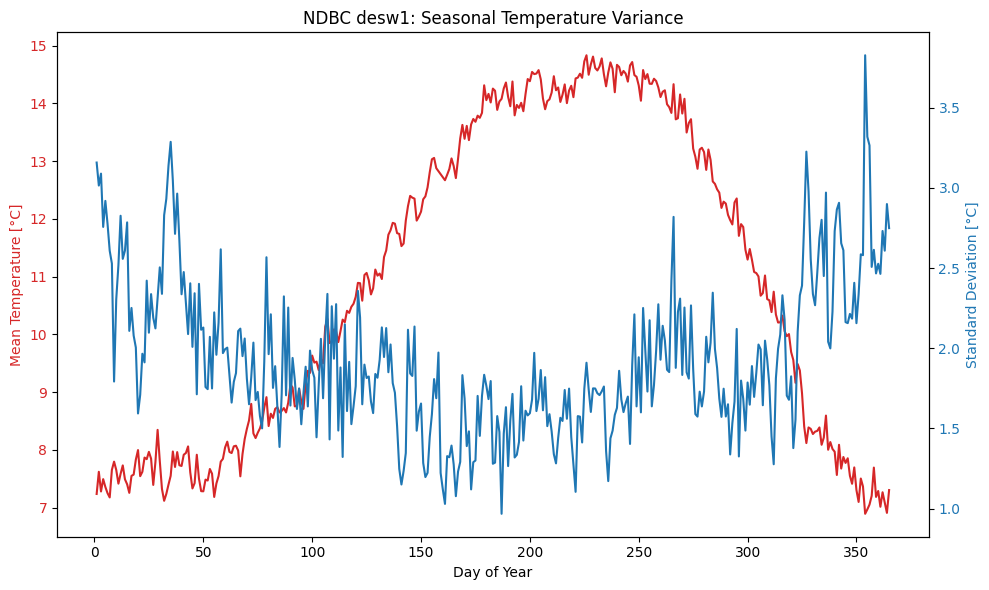

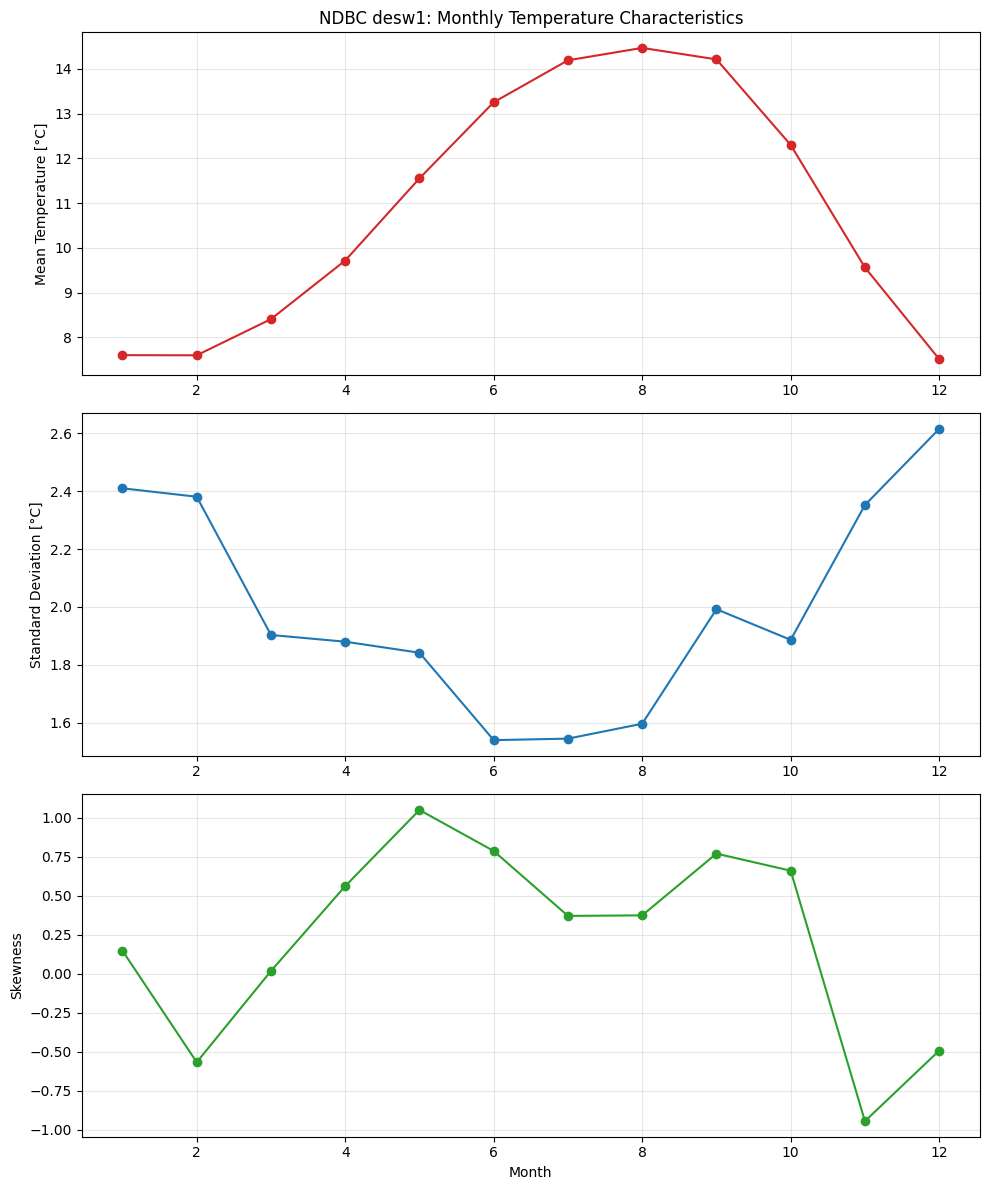

In [6]:
# Analyze variance patterns for each station
for station, data in station_data.items():
    print(f"\nAnalyzing variance patterns for station {station}")
    
    # Plot seasonal variance
    plot_variance(data, station)
    
    # Plot monthly distribution characteristics
    plot_variance_skew(data, station)